## 패키지 로드

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from konlpy.tag import Mecab
from collections import Counter

# 데이터 전처리

## 데이터 읽어오기

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    # 1. 데이터의 중복 제거 (리뷰-documnet가 중복된걸 제거하자)
    train_data.drop_duplicates(['document'], inplace=True)
    test_data.drop_duplicates(['document'], inplace=True)
    
    # 2. NaN 결측치 제거 (행기준)
    train_data.dropna(axis=0, how='any')
    test_data.dropna(axis=0, how='any')
    
    # 3. 한국어 토크나이저로 토큰화 (Mecab())
    # 4. 불용어 제거 (stopwords)
    X_train = []
    for i, sentence in enumerate(train_data['document']):
        try:
            tmp_x = tokenizer.morphs(sentence)
            tmp_x = [word for word in tmp_x if not word in stopwords]
            X_train.append(tmp_x)
        except:
            traindrop = i
        
    X_test = []
    for i, sentence in enumerate(test_data['document']):
        try:
            tmp_x = tokenizer.morphs(sentence)
            tmp_x = [word for word in tmp_x if not word in stopwords]
            X_test.append(tmp_x)
        except:
            testdrop = i
        
    # 2차월 배열을 1차원 리스트로 변환
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # counter 객체를 선언한다음 가장 많이 나온 순서대로 리스트화
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    
    # 5. 사전 word to index 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    print(traindrop, testdrop)
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    train_data.drop([i])
    test_data.drop([i])
    # 7. X_train, y_train, X_test, y_test, word_to_index 값 리턴하기
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

25521 5704


In [4]:
y_train = np.delete(y_train, 25521)
y_test = np.delete(y_test, 5704)

### 이게 무슨 에러람!?
morphs() 함수를 진행하다보니 train_data의 25521 번째의 데이터에서 다음과 같은 에러가 나왔다.  
> NotImplementedError: Wrong number or type of arguments for overloaded function 'Tagger_parse'.  

그래서 try except 구문으로 에러가 안나는 부분만 토큰화를 진행하였다.


### 단어 사전에 없지만 필요한 값들 추가

In [5]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

### index_to_word

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

### encoder, decoder

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 데이터셋 내 문장 길이 분포

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 문장의 길이 맞추기 - pad 추가
문장의 끝에 의미있는 값이 나오는게 성능에 좋다고 나와서 pre 옵션을 써준다.

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [10]:
print(X_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


## train셋에서 train과 val 세트 나누기 (약 8:2)

In [11]:
# validation set 분리 
X_val = X_train[116900:]   
y_val = y_train[116900:]

# validation set을 제외한 나머지
partial_X_train = X_train[:116900]  
partial_y_train = y_train[:116900]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116900, 41)
(116900,)


# 딥러닝 모델 설계와 훈련

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
# [[YOUR CODE]]
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 5s 7ms/step - loss: 0.4995 - accuracy: 0.7682 - val_loss: 0.3667 - val_accuracy: 0.8422
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3406 - accuracy: 0.8565 - val_loss: 0.3500 - val_accuracy: 0.8499
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3187 - accuracy: 0.8672 - val_loss: 0.3519 - val_accuracy: 0.8460
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3065 - accuracy: 0.8728 - val_loss: 0.3544 - val_accuracy: 0.8465
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2991 - accuracy: 0.8766 - val_loss: 0.3508 - val_accuracy: 0.8486
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2911 - accuracy: 0.8802 - val_loss: 0.3496 - val_accuracy: 0.8481
Epoch 7/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2824 - accuracy: 0.8841 - val_loss: 0.3500 - val_accuracy: 0.8504
Epoch 

In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3677 - accuracy: 0.8457
[0.3676881194114685, 0.8456781506538391]


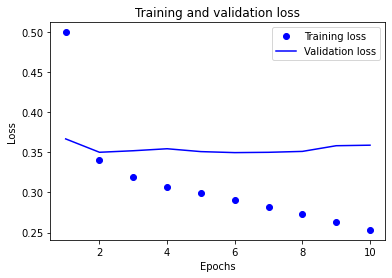

In [16]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### epoch 2부터 train loss 와 val loss가 벌어지는거 보니 학습에 의미가 없다...

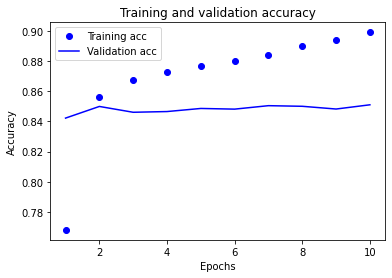

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.0021441 ,  0.02395369, -0.01168192,  0.09090191, -0.13208003,
       -0.01216575,  0.09478901,  0.01602021,  0.04110524,  0.12834188,
        0.03813002,  0.05657509, -0.03492283,  0.21783498, -0.02438914,
       -0.10055645], dtype=float32)

In [20]:
word_vectors.similar_by_word("영화")

[('게', 0.901257336139679),
 ('봄', 0.8784139156341553),
 ('줍니다', 0.8527549505233765),
 ('네요', 0.848176121711731),
 ('음', 0.8440788984298706),
 ('은지', 0.8369144797325134),
 ('남', 0.8320052623748779),
 ('........', 0.8199950456619263),
 ('.', 0.8191646337509155),
 ('된다면', 0.803630530834198)]

### 다양한 모델 사용해보기

- CNN 모델 사용해보기

In [21]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

cnn_history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 3s 6ms/step - loss: 0.5099 - accuracy: 0.7339 - val_loss: 0.3641 - val_accuracy: 0.8435
Epoch 2/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3333 - accuracy: 0.8585 - val_loss: 0.3503 - val_accuracy: 0.8475
Epoch 3/10
229/229 [==============================] - 1s 5ms/step - loss: 0.3000 - accuracy: 0.8751 - val_loss: 0.3410 - val_accuracy: 0.8537
Epoch 4/10
229/229 [==============================] - 1s 5ms/step - loss: 0.2745 - accuracy: 0.8878 - val_loss: 0.3410 - val_accuracy: 0.8552
Epoch 5/10
229/229 [==============================] - 1s 5ms/step - loss: 0.2461 - accuracy: 0.9025 - val_loss: 0.3535 - val_accuracy: 0.8538
Epoch 6/10
229/229 [==============================] - 1s 5ms/step - loss: 0.2164 - accuracy: 0.9169 - val_loss: 0.3730 - val_accuracy: 0.8510
Epoch 7/10
229/229 [==============================] - 1s 5ms/step - loss: 0.1857 - accuracy: 0.9319 - val_loss: 0.3975 - val_accuracy: 0.8463
Epoch 

In [23]:
results = cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5386 - accuracy: 0.8334
[0.5386031866073608, 0.8334316611289978]


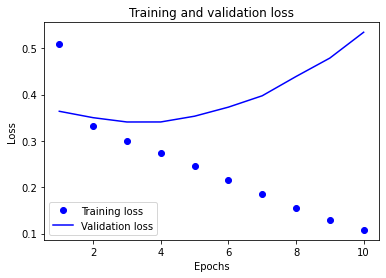

In [24]:
cnn_history_dict = cnn_history.history

import matplotlib.pyplot as plt

acc = cnn_history_dict['accuracy']
val_acc = cnn_history_dict['val_accuracy']
loss = cnn_history_dict['loss']
val_loss = cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

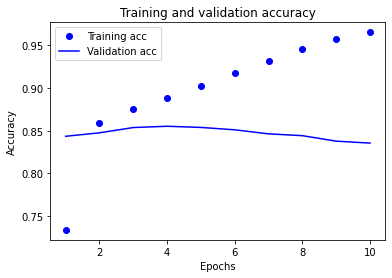

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
embedding_layer = cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("영화")

(10000, 16)


[('변해', 0.8248113989830017),
 ('열매', 0.7831493616104126),
 ('긍정', 0.7535608410835266),
 ('잔상', 0.7485314011573792),
 ('다이하드', 0.7257590889930725),
 ('충족', 0.7238792181015015),
 ('디즈니', 0.7201597690582275),
 ('기영', 0.7181894183158875),
 ('벅스', 0.7101703882217407),
 ('...........', 0.7059231996536255)]

- GlobalMaxPooling 사용해보기

In [27]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [28]:
gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

gmp_history = gmp_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 1s 4ms/step - loss: 0.6173 - accuracy: 0.7230 - val_loss: 0.4848 - val_accuracy: 0.8094
Epoch 2/10
229/229 [==============================] - 1s 4ms/step - loss: 0.4013 - accuracy: 0.8317 - val_loss: 0.3755 - val_accuracy: 0.8368
Epoch 3/10
229/229 [==============================] - 1s 4ms/step - loss: 0.3361 - accuracy: 0.8565 - val_loss: 0.3583 - val_accuracy: 0.8437
Epoch 4/10
229/229 [==============================] - 1s 3ms/step - loss: 0.3068 - accuracy: 0.8718 - val_loss: 0.3548 - val_accuracy: 0.8463
Epoch 5/10
229/229 [==============================] - 1s 3ms/step - loss: 0.2863 - accuracy: 0.8816 - val_loss: 0.3566 - val_accuracy: 0.8458
Epoch 6/10
229/229 [==============================] - 1s 4ms/step - loss: 0.2695 - accuracy: 0.8901 - val_loss: 0.3616 - val_accuracy: 0.8453
Epoch 7/10
229/229 [==============================] - 1s 4ms/step - loss: 0.2554 - accuracy: 0.8967 - val_loss: 0.3677 - val_accuracy: 0.8449
Epoch 

In [29]:
results = gmp_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4037 - accuracy: 0.8382
[0.4036770164966583, 0.8382325768470764]


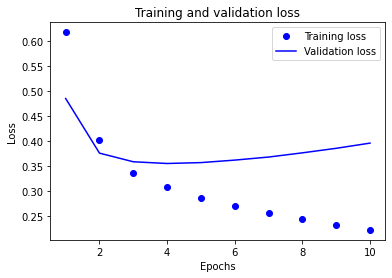

In [30]:
gmp_history_dict = gmp_history.history

import matplotlib.pyplot as plt

acc = gmp_history_dict['accuracy']
val_acc = gmp_history_dict['val_accuracy']
loss = gmp_history_dict['loss']
val_loss = gmp_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

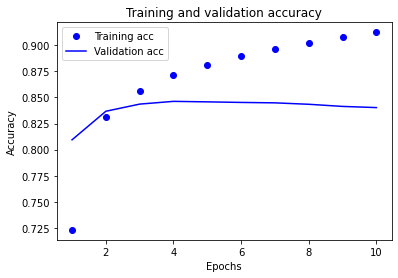

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
embedding_layer = gmp_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec_gmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = gmp_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("영화")

(10000, 16)


[('을', 0.9913325309753418),
 ('...', 0.9908831715583801),
 ('..', 0.9888812303543091),
 ('만드', 0.9846879839897156),
 ('같', 0.984250009059906),
 ('본', 0.9816907644271851),
 (',', 0.9814178347587585),
 ('언제', 0.9802953600883484),
 ('느낌', 0.9784504175186157),
 ('어', 0.9755862951278687)]

### 세가지 모델을 사용해봤지만 영화와 관련된 문자가 나오지는 않았다.
한글 Word2Vec을 활용해보자!  
버전을 낮추지 않고 (gensim 4.1.2) 실행했떠니 오류가 났었다.  
그래서 3.8.1점대로 낮추고 진행하엿다.

In [12]:
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector

/tmp/ipykernel_99/2032836925.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

### 미리 학습된 벡터를 이용하니 그래도 유사한 단어들이 나왔다.

In [13]:
word2vec.similar_by_word("영화")

/tmp/ipykernel_99/2210671227.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("영화")


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

### Word2Vec을 이용해서 모델 학습하기

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_99/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_99/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [35]:
from tensorflow.keras.initializers import Constant

# 모델 구성
W2V_model = tf.keras.Sequential()
W2V_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

W2V_model.add(tf.keras.layers.LSTM(48, activation='relu'))
W2V_model.add(tf.keras.layers.Dense(8, activation='relu'))
W2V_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

W2V_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                47808     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 392       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,048,209
Trainable params: 2,048,209
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 학습의 진행
W2V_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

W2V_history = W2V_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 19s 77ms/step - loss: 0.4894 - accuracy: 0.7555 - val_loss: 0.3957 - val_accuracy: 0.8212
Epoch 2/10
229/229 [==============================] - 17s 76ms/step - loss: 0.3511 - accuracy: 0.8469 - val_loss: 0.3453 - val_accuracy: 0.8480
Epoch 3/10
229/229 [==============================] - 17s 75ms/step - loss: 0.3044 - accuracy: 0.8707 - val_loss: 0.3293 - val_accuracy: 0.8585
Epoch 4/10
229/229 [==============================] - 17s 76ms/step - loss: 0.2786 - accuracy: 0.8836 - val_loss: 0.3265 - val_accuracy: 0.8610
Epoch 5/10
229/229 [==============================] - 17s 75ms/step - loss: 0.2595 - accuracy: 0.8922 - val_loss: 0.3271 - val_accuracy: 0.8611
Epoch 6/10
229/229 [==============================] - 17s 76ms/step - loss: 0.2401 - accuracy: 0.9024 - val_loss: 0.3303 - val_accuracy: 0.8648
Epoch 7/10
229/229 [==============================] - 17s 75ms/step - loss: 0.2230 - accuracy: 0.9108 - val_loss: 0.3559 - val_accuracy:

In [37]:
# 테스트셋을 통한 모델 평가
results = W2V_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 10s - loss: 0.4098 - accuracy: 0.8535
[0.4097968339920044, 0.8534694910049438]


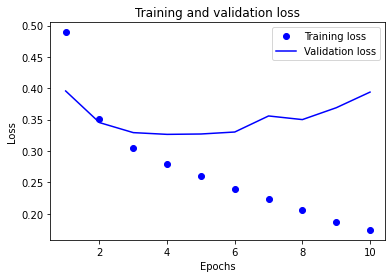

In [38]:
W2V_history_dict = W2V_history.history

import matplotlib.pyplot as plt

acc = W2V_history_dict['accuracy']
val_acc = W2V_history_dict['val_accuracy']
loss = W2V_history_dict['loss']
val_loss = W2V_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

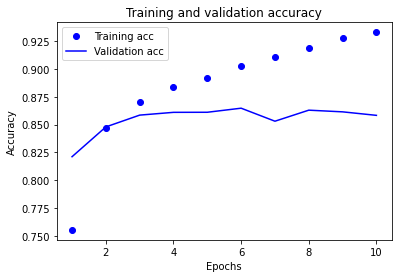

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
embedding_layer = W2V_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/my_word2vec_W2V.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = W2V_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

(10000, 200)


In [42]:
word_vectors.similar_by_word("영화")

[('다큐멘터리', 0.7283183932304382),
 ('영화사', 0.7134581208229065),
 ('드라마', 0.6989931464195251),
 ('뮤지컬', 0.6934480667114258),
 ('코미디', 0.6843423843383789),
 ('영화인', 0.6625460386276245),
 ('스릴러', 0.6605284810066223),
 ('애니메이션', 0.638838529586792),
 ('로맨스', 0.6348001956939697),
 ('시트콤', 0.6181972026824951)]

In [43]:
word_vectors.similar_by_word("대박")

[('이만', 0.4694383442401886),
 ('삽입곡', 0.46221593022346497),
 ('하이라이트', 0.4596475660800934),
 ('ㅠㅠ', 0.4592939019203186),
 ('여운', 0.4485509395599365),
 ('후편', 0.44719362258911133),
 ('보람', 0.44626039266586304),
 ('절규', 0.44622570276260376),
 ('재밌', 0.4442387819290161),
 ('울림', 0.4441693127155304)]

In [44]:
word_vectors.similar_by_word("별로")

[('그다지', 0.5364997982978821),
 ('따로', 0.49396246671676636),
 ('전혀', 0.4821472465991974),
 ('딱히', 0.4795222282409668),
 ('별반', 0.4722910523414612),
 ('마다', 0.46448707580566406),
 ('별', 0.43834179639816284),
 ('각', 0.43156740069389343),
 ('다소', 0.3967580199241638),
 ('대체로', 0.39293810725212097)]

In [45]:
word_vectors.similar_by_word("재미")

[('취미', 0.5773895978927612),
 ('매력', 0.5613220930099487),
 ('유머', 0.5177605748176575),
 ('흥미', 0.5098336935043335),
 ('향수', 0.4934113621711731),
 ('즐거움', 0.47398313879966736),
 ('개그', 0.4718540906906128),
 ('말투', 0.4639205038547516),
 ('카리스마', 0.4590345621109009),
 ('호기심', 0.45643192529678345)]

In [47]:
word_vectors.similar_by_word("실망")

[('당황', 0.7323004007339478),
 ('분노', 0.677782416343689),
 ('경악', 0.672283411026001),
 ('원망', 0.5859050154685974),
 ('후회', 0.5831568241119385),
 ('걱정', 0.5687434077262878),
 ('감동', 0.5684541463851929),
 ('무식', 0.565112829208374),
 ('조심', 0.5573939085006714),
 ('열광', 0.5551813840866089)]

## 회고

이번 Exploration에서는 내가 만든 워드 벡터와 전이학습을 통해 만든 벡터의 차이점을 알 수 있는 섹션이였다.  
내가 만든 벡터는 단순히 자주 나온 순으로 정렬을해서 벡터화를 시켜서 그런지는 몰라도 "영화" 라는 단어에 엉뚱한 값들이 나왔다.  
이를 바탕으로 세가지 모델로 학습을 해서 정확도가 약 80~83%가 나왓지만, 결과는 엉뚱한 값이 나왔다.  
하지만 한국어 word2vec을 이용해서 의미가 유사한 단어들을 뽑으니 납득이 갈만한 단어들이 나왔다.  

Exploration 중간에 나온 에뛰드하우스의 경우처럼 영화에서 자주 나오는 말이나, 신조어 사전들을 추가한다면 어떻게 될지 궁금하다.  
아직은 코드의 흐름을 이해하기에 급급해서 추가적인 실험은 하지 못했지만, 앞으로 열심히 배워서 사전을 추가한던가, 불용어를 좀 더 추가하거 수정해서 좀더 나은 성능을 가진 모델을 해봐야겠다.